In [1]:
import numpy as np
import matplotlib.pyplot as plt

(-7970373.107250562, 8845022.100930313, -8259795.995144906, 9098137.602880096)

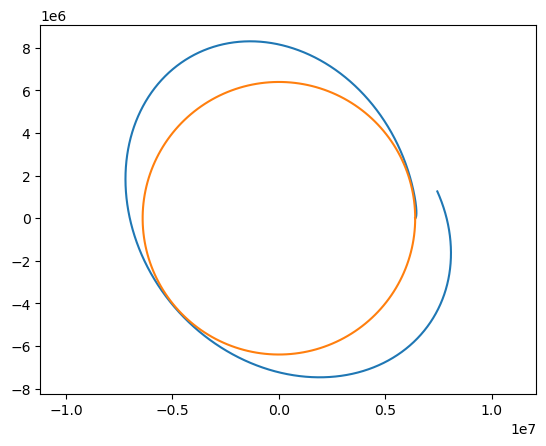

In [98]:
g=9.8
Isp=320*g
dt=1

position_i=[np.array([6400e3,0,0])]
acceleration_i=[np.array([0,0,0])]
velocity_i=[np.array([1,0,0])]
orientation=[np.array([1,0,0])]
mass=5e6
prop_mass=mass*0.97
thrust=mass*g*1.3
time=0
t_target=60*100


while prop_mass>0 or time<t_target:
    if thrust/mass/g>4:
        thrust=mass*g*4
    if prop_mass<0:
        thrust=0
    m_dot=thrust/Isp
    gravity=-g*position_i[-1]/np.linalg.norm(position_i[-1])
    thrust_vector=thrust*velocity_i[-1]/np.linalg.norm(velocity_i[-1])
    if time>10 and time<80:
        theta_=0.0059
        Rz = np.array([
                                [ np.cos(theta_), -np.sin(theta_), 0],
                                [np.sin(theta_), np.cos(theta_), 0],
                                [0,             0,                1]
                            ])
        thrust_vector=Rz@thrust_vector
    acceleration_i+=[thrust_vector/mass+gravity]
    velocity_i+=[velocity_i[-1]+acceleration_i[-1]*dt]
    position_i+=[position_i[-1]+velocity_i[-1]*dt+0.5*acceleration_i[-1]*dt*dt]
    mass-=m_dot*dt
    prop_mass-=m_dot*dt
    time+=dt

n=0
position_i_array=np.array(position_i)
position_i_array=position_i_array.T
if n>0:
    plt.plot(position_i_array[0][0:n+1],position_i_array[1][0:n+1])
else:
    plt.plot(position_i_array[0],position_i_array[1])
angles=np.linspace(0,np.pi*2,200)
plt.plot(6400e3*np.cos(angles),6400e3*np.sin(angles))
plt.axis("equal")

(-7435484.277959231, 8135586.597704243, -8691135.92551663, 9184786.213859662)

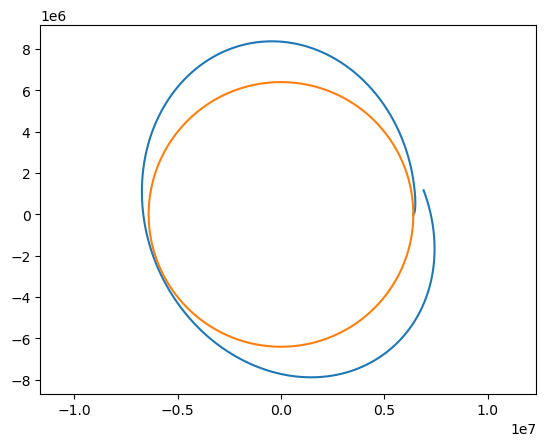

In [94]:
n=0
position_i_array=np.array(position_i)
position_i_array=position_i_array.T
if n>0:
    plt.plot(position_i_array[0][0:n+1],position_i_array[1][0:n+1])
else:
    plt.plot(position_i_array[0],position_i_array[1])
angles=np.linspace(0,np.pi*2,200)
plt.plot(6400e3*np.cos(angles),6400e3*np.sin(angles))
plt.axis("equal")

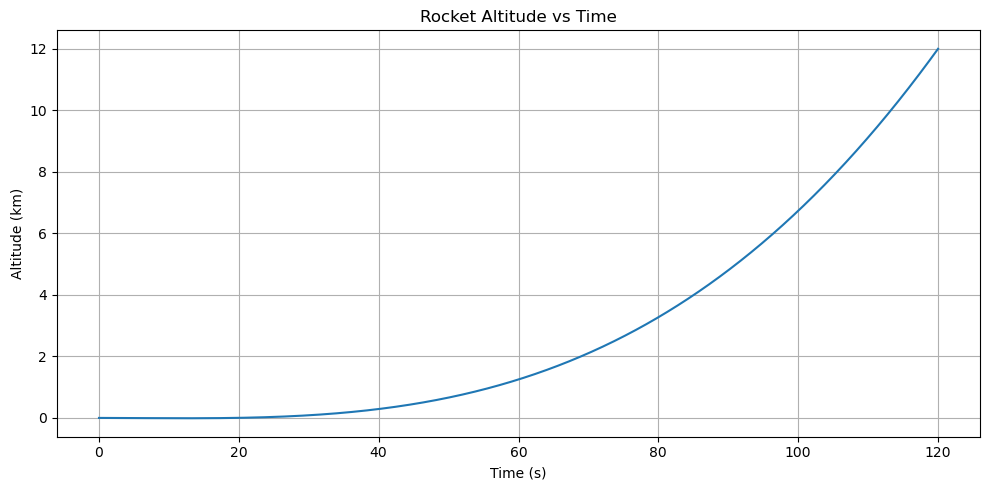

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# === Constants ===
mu_earth = 3.986004418e14  # m^3/s^2, gravitational parameter of Earth
R_earth = 6371e3  # m, Earth radius

# === Quaternion Functions ===
def normalize_quaternion(q):
    return q / np.linalg.norm(q)

def quaternion_derivative(q, omega):
    p, q_b, r = omega
    omega_mat = np.array([
        [ 0,   -p,   -q_b, -r],
        [ p,    0,    r,  -q_b],
        [ q_b, -r,    0,   p],
        [ r,   q_b,  -p,   0]
    ])
    return 0.5 * omega_mat @ q

def quaternion_to_dcm(q):
    q0, q1, q2, q3 = q
    return np.array([
        [1 - 2*(q2**2 + q3**2),     2*(q1*q2 - q0*q3),     2*(q1*q3 + q0*q2)],
        [2*(q1*q2 + q0*q3),         1 - 2*(q1**2 + q3**2), 2*(q2*q3 - q0*q1)],
        [2*(q1*q3 - q0*q2),         2*(q2*q3 + q0*q1),     1 - 2*(q1**2 + q2**2)]
    ])

# === Simulation Parameters ===
dt = 0.1     # time step (s)
T = 120      # total simulation time (s)
N = int(T / dt)

# === Initial Conditions ===
r = np.array([R_earth, 0, 0], dtype=np.float64)  # Initial position (on equator)
v = np.array([0, 7800, 0], dtype=np.float64)     # Initial orbital velocity
q = np.array([1.0, 0.0, 0.0, 0.0])               # Identity quaternion (no rotation)
omega_body = np.radians([0.1, 0.2, 0.1])         # Angular velocity in body frame

mass = 500000.0      # kg
thrust_mag = 7e6     # N
thrust_body = np.array([0, 0, 1])  # +Z thrust in body frame

# === Storage Arrays ===
r_history = np.zeros((N, 3))
v_history = np.zeros((N, 3))
q_history = np.zeros((N, 4))
altitude = np.zeros(N)

# === Simulation Loop ===
for i in range(N):
    r_history[i] = r
    v_history[i] = v
    q_history[i] = q
    altitude[i] = np.linalg.norm(r) - R_earth

    # Update quaternion from body angular velocity
    dqdt = quaternion_derivative(q, omega_body)
    q += dqdt * dt
    q = normalize_quaternion(q)

    # Rotate thrust vector from body to ECI
    R_b_to_i = quaternion_to_dcm(q)
    thrust_eci = R_b_to_i @ thrust_body * thrust_mag

    # Gravitational acceleration (central gravity)
    a_gravity = -mu_earth * r / np.linalg.norm(r)**3

    # Total acceleration
    a = a_gravity + thrust_eci / mass

    # Update velocity and position
    v += a * dt
    r += v * dt

# === Plot Altitude Over Time ===
time = np.linspace(0, T, N)
plt.figure(figsize=(10, 5))
plt.plot(time, altitude / 1000)  # km
plt.title("Rocket Altitude vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Altitude (km)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [156]:
import matplotlib.pyplot as plt
import numpy as np
class traj:
    def __init__(self):
        g=9.8
        self.mass=3e6
        self.propellant_mass=self.mass*0.954
        self.thrust_to_weight_initial=1.8
        self.isp=320*g
        self.inertia_matrix=self.rocket_inertia_tensor(self.mass,100,8)
        self.thrust_position=np.array([0,0,-30])
        self.thrust=self.mass*self.thrust_to_weight_initial*g
        self.position=[np.array([6400e3,0,0])]
        self.velocity=[np.array([0,465,0])]
        self.acceleration=[np.array([0,0,0])]
        self.orientation=[np.array([1,0,0])]
        self.q=np.array([1/(2)**0.5,0,1/(2)**0.5,0])
        #self.q=np.array([1.0,0.0,0.0,0.0])
        self.time=[0]

    def rocket_inertia_tensor(self,mass, radius, length):
        I_xx = (1/12) * mass * (3 * radius**2 + length**2)
        I_zz = 0.5 * mass * radius**2
        return np.diag([I_xx, I_xx, I_zz])
    
    def normalize_quaternion(q):
        return q / np.linalg.norm(q)

    def quaternion_derivative(q, omega):
        p, q_b, r = omega
        omega_mat = np.array([
            [ 0,   -p,   -q_b, -r],
            [ p,    0,    r,  -q_b],
            [ q_b, -r,    0,   p],
            [ r,   q_b,  -p,   0]
        ])
        return 0.5 * omega_mat @ q

    def quaternion_to_dcm(q):
        q0, q1, q2, q3 = q
        return np.array([
            [1 - 2*(q2**2 + q3**2),     2*(q1*q2 - q0*q3),     2*(q1*q3 + q0*q2)],
            [2*(q1*q2 + q0*q3),         1 - 2*(q1**2 + q3**2), 2*(q2*q3 - q0*q1)],
            [2*(q1*q3 - q0*q2),         2*(q2*q3 + q0*q1),     1 - 2*(q1**2 + q2**2)]
        ])

    
    def model(self,time=60*10,theta_=-0.1):
        dt=0.1
        g=9.8
        while self.propellant_mass>0 or self.time[-1]<time:
            if self.propellant_mass<0:
                self.thrust=0
            if self.thrust>4:
                self.thrust=self.mass*4*g
            m_dot=self.thrust/self.isp
            if self.time[-1]>10 and self.time[-1]<300:
                theta = theta_
            else:
                theta=0
            Rx = np.array([ [1      , 0            , 0],
                            [0      , np.cos(theta), -np.sin(theta)],
                            [0      , np.sin(theta),  np.cos(theta)]
                          ])
            
            thrust_body_frame=Rx@np.array([0,0,self.thrust])
            torque_body_frame=np.cross(self.thrust_position,thrust_body_frame)
            omega_body_frame=np.linalg.solve(self.inertia_matrix,torque_body_frame)

            R_b_to_i = quaternion_to_dcm(self.q)
            thrust_eci_frame = R_b_to_i @ thrust_body_frame
            
            gravity_eci_frame=-g*normalize_quaternion(self.position[-1])

            self.acceleration+=[thrust_eci_frame/self.mass+gravity_eci_frame]
            self.velocity+=[self.velocity[-1]+self.acceleration[-1]*dt]
            self.position+=[self.position[-1]+self.velocity[-1]*dt+0.5*self.acceleration[-1]*dt*dt]

            dqdt = quaternion_derivative(self.q, omega_body_frame)
            self.q += dqdt * dt
            self.q = normalize_quaternion(self.q)

            self.mass-=m_dot*dt
            self.propellant_mass-=m_dot*dt

            #if np.abs(self.time[-1]%10)<0.05:
                #print(self.time[-1])
                #print(dqdt,omega_body_frame,torque_body_frame)
                #print(self.acceleration[-1])
            
            self.time+=[self.time[-1]+dt]
            
        
    def plot_position(self):
        n=0
        plt.figure()
        position_i_array=np.array(self.position)
        position_i_array=position_i_array.T
        if n>0:
            plt.plot(position_i_array[0][0:n+1],position_i_array[1][0:n+1])
        else:
            plt.plot(position_i_array[0],position_i_array[1])
        angles=np.linspace(0,np.pi*2,200)
        plt.plot(6400e3*np.cos(angles),6400e3*np.sin(angles))
        plt.axis("equal")
        plt.xlim([np.min(position_i_array[0]-1000e3),np.max(position_i_array[0]+1000e3)])
        plt.ylim([np.min(position_i_array[1]-1000e3),np.max(position_i_array[1]+1000e3)])

    def plot_altitudes(self):
        plt.figure()
        altitudes=[(np.linalg.norm(self.position[i])-6400e3)/1e3 for i in range(0,len(self.position))]
        print(np.average(altitudes))
        plt.plot(self.time,altitudes)



354.03699476290194


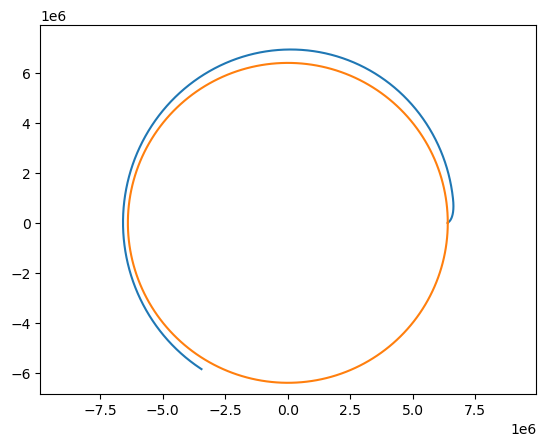

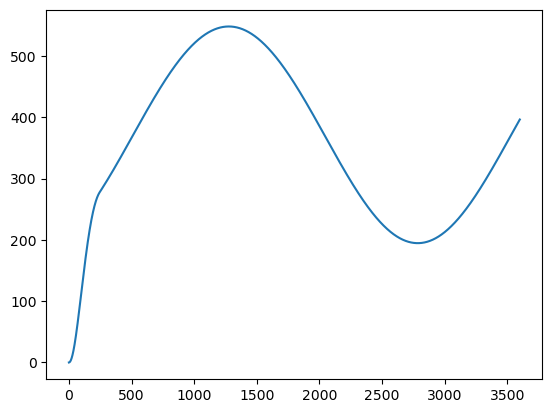

In [158]:

a=traj()
a.model(time=60*60,theta_=0.065)
a.plot_position()
a.plot_altitudes()

In [3]:
import time
t=time.time()
time.sleep(1)
time.time()-t

1.0010154247283936

In [52]:
import numpy as np
import matplotlib.pyplot as plt
R=6400e3
r=R+500e3
position=[np.array([r,0])]
v=(9.8/r)**0.5*R
velocity=[np.array([0,v])]
dt=1
t=0
alt=[np.linalg.norm(position[-1])]
while t<10000:
    #print(9.8*(R**2/np.linalg.norm(position[-1])**2)-np.linalg.norm(velocity[-1])**2/np.linalg.norm(position[-1]))
    a=-9.8*(R**2/np.linalg.norm(position[-1])**2)*position[-1]/np.linalg.norm(position[-1])
    velocity+=[velocity[-1]*1+a*dt]
    position+=[position[-1]*1+velocity[-1]*dt+0.5*a*dt**2]
    alt+=[np.linalg.norm(position[-1])]
    
    t+=dt
position=np.array(position).T

(-7564848.854590113, 7588802.326409053, -7551629.800380666, 7575633.559918041)

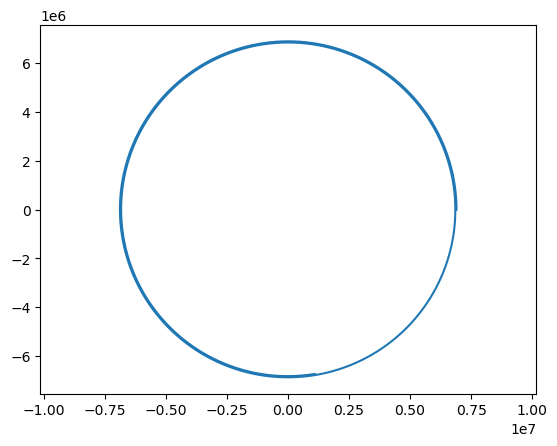

In [53]:
plt.plot(position[0],position[1])
plt.axis('equal')

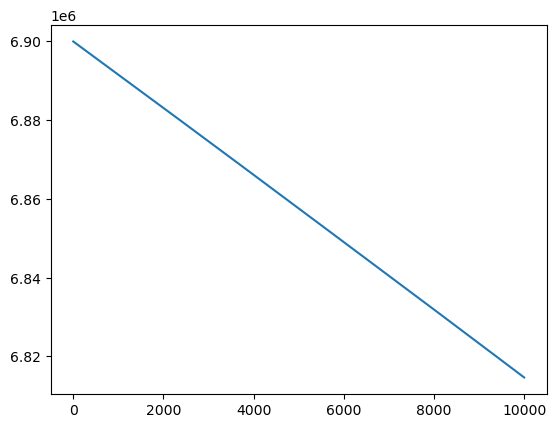

In [54]:
plt.plot(alt)

In [40]:
R**2/r**2

0.8603234614576769

In [1]:
pip install tqdm


Note: you may need to restart the kernel to use updated packages.


The value specified in an AutoRun registry key could not be parsed.


In [17]:
from tqdm import tqdm
import time

for i in tqdm(range(100)):
    #print(i)
    time.sleep(0.05)  # simulate work


100%|██████████| 100/100 [00:05<00:00, 19.30it/s]


In [13]:
import time
import sys

def custom_progress_bar(iterable, prefix="", size=60):
    count = len(iterable)

    def show(j):
        x = int(size * j / count)
        sys.stdout.write(f"\r{prefix}[{'█' * x}{'.' * (size - x)}] {j}/{count}")
        sys.stdout.flush()

    show(0)
    for i, item in enumerate(iterable):
        time.sleep(0.1)  # simulate work
        show(i + 1)
    print()

custom_progress_bar(range(100), prefix="Progress:")


Progress:[████████████████████████████████████████████████████████████] 100/100


In [14]:
from tqdm import tqdm
import time
with tqdm(total=100) as pbar:
    for i in range(10):
        time.sleep(0.5)
        pbar.update(10)


100%|██████████| 100/100 [00:05<00:00, 19.88it/s]
